# M7 Project
Ehab Ebeid

## Setup

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geocoder as gc
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [2]:
def pickle_it(obj, file_path):
    """Pickles obj and saves it as file_path"""
    f = open(file_path,'wb')
    pickle.dump(obj,f)
    f.close()

def unpickle(file_path):
    """Return object pickled at file_path"""
    f = open(file_path,'rb')
    return pickle.load(f)

In [96]:
sns.set_palette("colorblind")

## Schools

### Retrieve schools from list provided by MBTA

In [4]:
schools = pd.read_csv("schoolinfo_20190517.csv")

In [5]:
schools.head()

,id,cat,name,am_anchor,pm_anchor,address
0,16,Private Special Ed School,ACCEPT COLLAB (NATICK),7:45 AM,2:40 PM,4 Tech Circle NATICK MA 01760
1,36,Private Special Ed School,ACCEPT COLLAB (MEDWAY),7:45 AM,2:40 PM,88 Summer Street Medway 02053
2,46,Private Special Ed School,BICO Collab,8:00 AM,2:40 PM,141 MANSION DRIVE EAST WALPOLE MA 02032
3,59,Private Special Ed School,Bay Cove HS,7:50 AM,2:30 PM,156 Lawton St Brookline MA 02446
4,90,Private Special Ed School,BEVERLY SCHL / DEAF,8:35 AM,3:00 PM,6 ECHO AV BEVERLY MA 01915


### Geocode using Google Maps API

In [10]:
api_key_file = open("api_key.txt")
api_key = api_key_file.read()

Comment out the code below because this only needs to be done once.

After the geocoding is done, save the results locally. 

In [11]:
addresses = list(schools.address)
geocodes = []

# comment out below because Google API calls
# api_key = "ABCD"
# for address in addresses:
#     pair = gc.google(address, key=api_key).latlng
#     lat = pair[0]
#     lon = pair[1]
#     geocodes.append((lat,lon))
    
# schools[['lat', 'lon']] = pd.DataFrame(geocodes, index=schools.index)
# schools.to_csv("schoolinfo_20190517_geocoded.csv")

In [6]:
schools = pd.read_csv("schoolinfo_20190517_geocoded.csv")

In [7]:
schools.head()

,Unnamed: 0,id,cat,name,am_anchor,pm_anchor,address,lat,lon
0,0,16,Private Special Ed School,ACCEPT COLLAB (NATICK),7:45 AM,2:40 PM,4 Tech Circle NATICK MA 01760,42.315199,-71.338551
1,1,36,Private Special Ed School,ACCEPT COLLAB (MEDWAY),7:45 AM,2:40 PM,88 Summer Street Medway 02053,42.153180,-71.438214
2,2,46,Private Special Ed School,BICO Collab,8:00 AM,2:40 PM,141 MANSION DRIVE EAST WALPOLE MA 02032,42.164104,-71.220562
3,3,59,Private Special Ed School,Bay Cove HS,7:50 AM,2:30 PM,156 Lawton St Brookline MA 02446,42.349940,-71.126563
4,4,90,Private Special Ed School,BEVERLY SCHL / DEAF,8:35 AM,3:00 PM,6 ECHO AV BEVERLY MA 01915,42.556593,-70.892950


### Turn into GeoDataFrame

In [99]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(schools.lon, schools.lat)]
schools_gdf = gpd.GeoDataFrame(schools, geometry=geometry)
schools_gdf.crs = {'init': 'epsg:3857', 'no_defs': True}
schools_gdf.head()

,Unnamed: 0,id,cat,name,am_anchor,pm_anchor,address,lat,lon,geometry
0,0,16,Private Special Ed School,ACCEPT COLLAB (NATICK),7:45 AM,2:40 PM,4 Tech Circle NATICK MA 01760,42.315199,-71.338551,POINT (-71.338551 42.315199)
1,1,36,Private Special Ed School,ACCEPT COLLAB (MEDWAY),7:45 AM,2:40 PM,88 Summer Street Medway 02053,42.153180,-71.438214,POINT (-71.4382143 42.15318)
2,2,46,Private Special Ed School,BICO Collab,8:00 AM,2:40 PM,141 MANSION DRIVE EAST WALPOLE MA 02032,42.164104,-71.220562,POINT (-71.2205623 42.16410399999999)
3,3,59,Private Special Ed School,Bay Cove HS,7:50 AM,2:30 PM,156 Lawton St Brookline MA 02446,42.349940,-71.126563,POINT (-71.1265626 42.34993970000001)
4,4,90,Private Special Ed School,BEVERLY SCHL / DEAF,8:35 AM,3:00 PM,6 ECHO AV BEVERLY MA 01915,42.556593,-70.892950,POINT (-70.89295 42.556593)


### School Category Exploration

In [100]:
schools_gdf.cat.unique()

array(['Private Special Ed School', '7 - 12', '9 - 12', '2-12', '6 - 12',
       '1 - 12', '6-8', '9-12', 'K-5', '6 - 8', 'K - 5', 'K - 2', 'K-3',
       'K - 8', 'K-1', 'K - 1', '2 - 8', 'K - 3', 'K - 6', '3 - 8',
       'K - 12', 'Charter', 'Catholic', 'BPS', 'Private'], dtype=object)

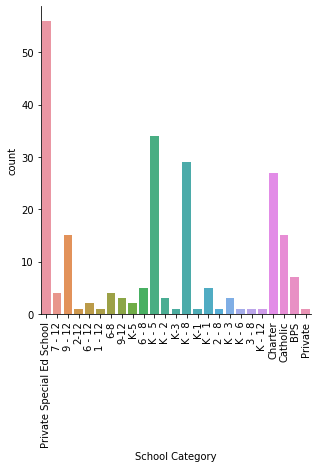

In [101]:
plot = sns.catplot(x="cat", kind="count", data=schools_gdf)
plot.set_xticklabels(rotation=90)
plt.xlabel("School Category")
plt.show()

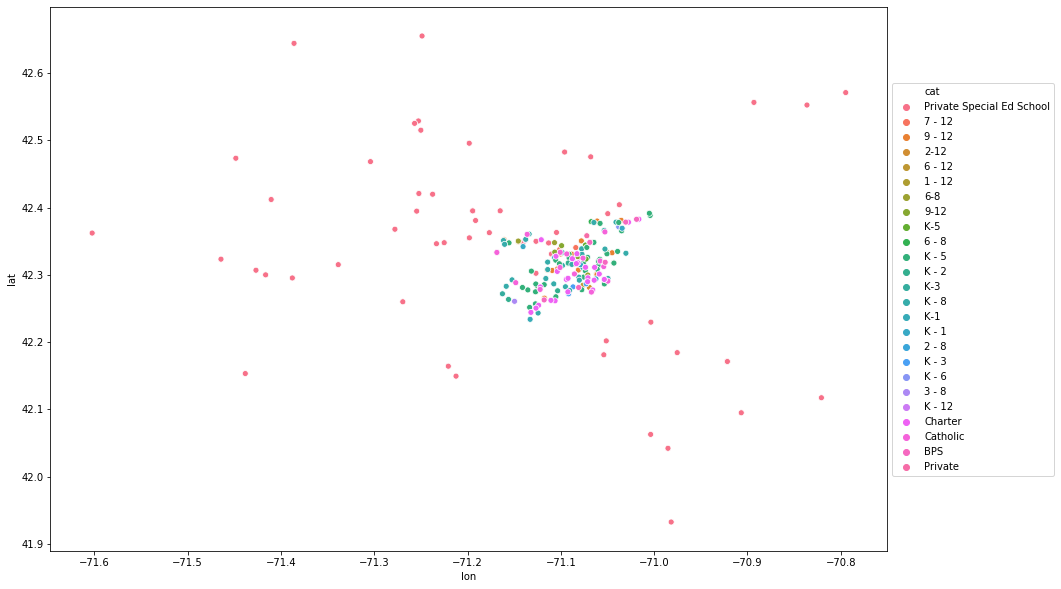

In [102]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(ax=ax, x="lon", y="lat", hue="cat", data=schools_gdf)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
plt.show()

Okay, that was illegible.

We need a more simple category to see what's happening.  
Assumption: 'BPS' and all the categories specified by grade number can be collapsed into a single meaningful category. The others ['Private Special Ed School','Charter', 'Catholic', 'Private'] can be retained. This means five categories in total.

In [103]:
schools_gdf['cats'] = np.where(schools_gdf.cat.isin(['Private Special Ed School','Charter', 'Catholic', 'Private']), schools_gdf.cat, "BPS")

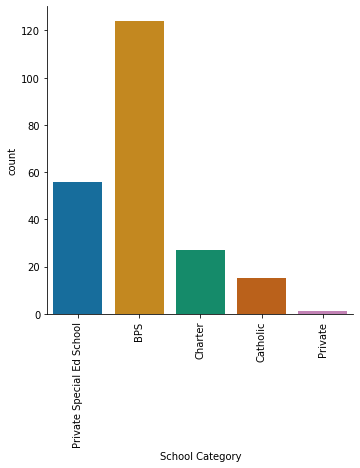

In [104]:
plot = sns.catplot(x="cats", kind="count", data=schools_gdf)
plot.set_xticklabels(rotation=90)
plt.xlabel("School Category")
plt.show()

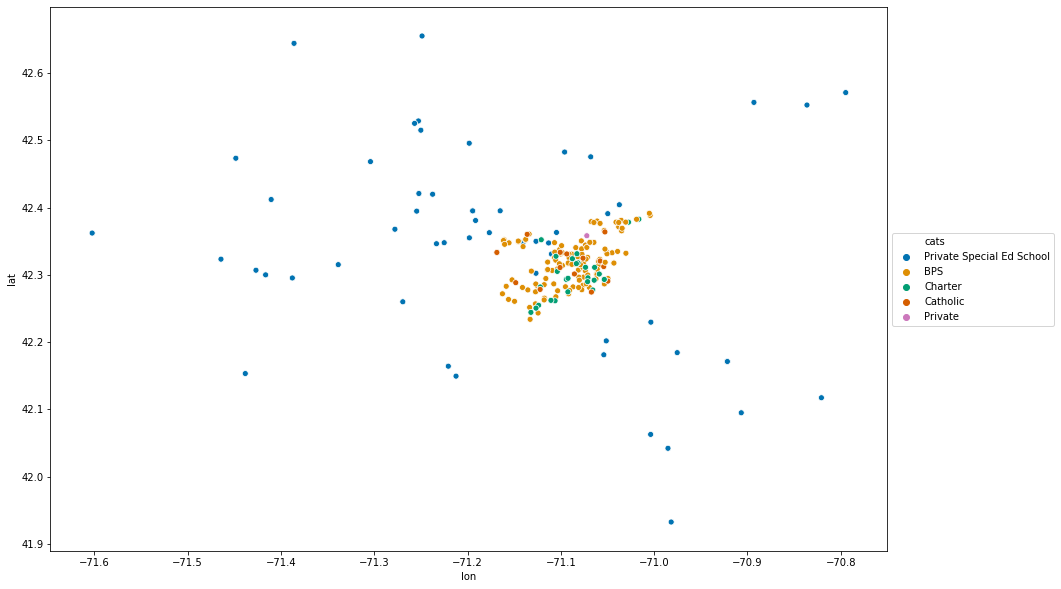

In [105]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(ax=ax, x="lon", y="lat", hue="cats", data=schools_gdf)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
plt.show()

It seems like all schools are in the City of Boston, as expected, except for the Private Special Ed schools. Can I safely exclude them so as to not complicate my analysis? Are the non-public schools in the list given M7 cards too?

### Create interactive map

This is to check the characteristics of a specific school based on its location.

In [106]:
import folium

school_map = folium.Map([42.3, -71.2], zoom_start = 10, tiles='cartodbpositron')

def color(cats):
    if cats == 'Private Special Ed School':
        return 'blue'
    elif cats == 'Charter':
        return 'green'
    elif cats == 'Catholic':
        return 'darkred'
    elif cats == 'Private':
        return 'purple'
    else:
        return 'orange'

def add_points(mapobj, gdf, popup_field_list):
    #Create a Folium feature group for this layer
    pt_lyr = folium.FeatureGroup(name = 'pt_lyr')
    for i, row in gdf.iterrows():
        #Append lat and long coordinates to "coords" list
        coords = (row.geometry.y, row.geometry.x)
        #Create a string of HTML code used in the IFrame popup
        #Join together the fields in "popup_field_list" with a linebreak between them
        cats = row['cats']
        icon = folium.Icon(color=color(cats), icon = 'school')
        label = '<br>'.join([field + ": " + row[field] for field in popup_field_list])
        #Append an IFrame that uses the HTML string to the "popups" list
        iframe = folium.IFrame(label, width = 300, height = 100)
        popup = folium.Popup(iframe, max_width=2000)
        pt_lyr.add_child(folium.Marker(location = coords, popup = popup, icon=icon))
    
    
    #Add this point layer to the map object
    mapobj.add_child(pt_lyr)
    return mapobj

school_map = add_points(school_map, schools_gdf, ['name','cat','am_anchor','pm_anchor','address'])
school_map
# ax = schools_gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

### Exclude some school types

I need to check with MBTA to see which of these categories should be kept.

In [107]:
exclusions = ['Private Special Ed School', 'Charter', 'Catholic', 'Private']
schools_gdf = schools_gdf[~schools_gdf.cat.isin(exclusions)]

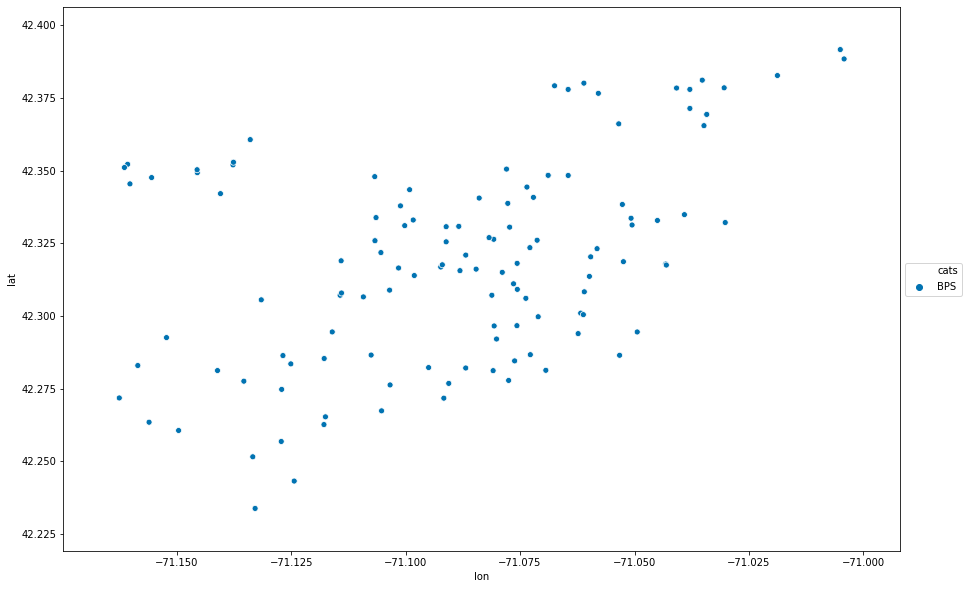

In [108]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(ax=ax, x="lon", y="lat", hue="cats", data=schools_gdf)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)
plt.show()

### Buffer

In [109]:
schools_gdf.to_csv("shp\schools.csv")

Create 0.25 and 0.5 mile buffers in ArcGIS and import them here.

In [110]:
buffer_q = gpd.read_file("shp\schools_buffer0.25.shp")

In [111]:
buffer_h = gpd.read_file("shp\schools_buffer0.5.shp")

In [112]:
buffer_q.crs

{'init': 'epsg:4326'}

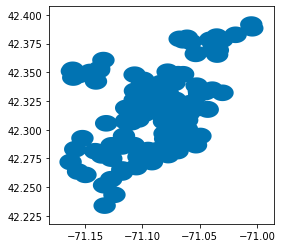

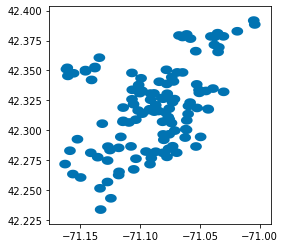

In [113]:
buffer_h.plot()
buffer_q.plot()
plt.show()

## Trips

### Join tables and retrieve stages for 2018-19 BPS cards.
Use ODX, fare, GTFS, and BPS tables. 

In [12]:
query = """
SELECT 
	odx.card, 
	bps.type, 
	odx.tap_time, 
	ftk.faretransactionkey ftk,
	journey_sequence jnysqn,
	stage,
	run_key,
	nstages,
	origin_time o_time,
	o.stop_id o_stop_id,
	o.stop_name o_stop_name,
	o.stop_lat o_stop_lat,
	o.stop_lon o_stop_lon,
	o.parent_station o_parent,
	destination_time d_time,
	d.stop_id d_stop_id,
	d.stop_name d_stop_name,
	d.stop_lat d_stop_lat,
	d.stop_lon d_stop_lon,
	d.parent_station d_parent
	
FROM playpen.bps_unique_201819 bps

join odx.odx odx
	on bps.hashed = odx.card
join afc.faretransaction ftk
	on ftk.faretransactionkey = odx.faretransactionkey
join gtfs.stops_20190917_20191221 o
	on o.stop_id = odx.origin
left join gtfs.stops_20190917_20191221 d
	on d.stop_id = odx.destination

where tap_time >= '2018-09-01'
  and hashed is not null
  and bps.hashed = odx.card
  and ftk.faretransactionkey = odx.faretransactionkey
  and origin is not null
;
"""
# import psycopg2
# import ssl
# import pandas.io.sql as sqlio

# conn = psycopg2.connect(
#     host = 'mbta01.mghpcc.org',
#     port = 5432,
#     user = 'ehab',
#     password = '',
#     sslmode = 'verify-full',
#     sslrootcert = '../postgresql/root-ca.crt',
#     sslcert = '../postgresql/ehab.crt',
#     sslkey = '../postgresql/ehab.key',
#     database = 'mbta_dw')

# df = sqlio.read_sql_query(query, conn)

In [2]:
import time

localtime = time.asctime( time.localtime(time.time()) )
print ("Local current time :", localtime)

Local current time : Tue Oct  1 00:05:29 2019


In [4]:
df.to_csv("faredata.csv")

In [8]:
faredata = pd.read_csv("faredata_201910010008.csv")

In [12]:
faredata.head()

,Unnamed: 0,card,type,tap_time,ftk,jnysqn,stage,run_key,nstages,o_time,...,o_stop_name,o_stop_lat,o_stop_lon,o_parent,d_time,d_stop_id,d_stop_name,d_stop_lat,d_stop_lon,d_parent
0,0,007BxvQ19BIJkVbZ2lgHq.bO1E57FSG,m7,2018-09-11 14:26:27.000,2139359586,1,1,2825,1,2018-09-11 14:26:27.000,...,Back Bay,42.347350,-71.075727,NaN,2018-09-11 14:59:10.000,place-asmnl,Ashmont,42.284652,-71.064489,NaN
1,1,007BxvQ19BIJkVbZ2lgHq.bO1E57FSG,m7,2018-09-11 15:36:44.000,2131931772,2,1,2825,1,2018-09-11 15:36:44.000,...,Ashmont,42.284652,-71.064489,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,007BxvQ19BIJkVbZ2lgHq.bO1E57FSG,m7,2018-09-11 15:44:10.000,2139608335,3,1,2825,1,2018-09-11 15:44:29.000,...,Ashmont,42.284195,-71.063879,place-asmnl,NaN,NaN,NaN,NaN,NaN,NaN
3,3,007BxvQ19BIJkVbZ2lgHq.bO1E57FSG,m7,2018-09-12 07:05:57.000,2133625204,1,1,2826,2,2018-09-12 07:06:11.000,...,Morton St @ Evans St,42.280886,-71.084654,NaN,2018-09-12 07:27:07.000,875,Forest Hills,42.300479,-71.113634,place-forhl
4,4,007BxvQ19BIJkVbZ2lgHq.bO1E57FSG,m7,2018-09-12 07:31:19.000,2138813823,1,2,2826,2,2018-09-12 07:31:19.000,...,Forest Hills,42.300523,-71.113686,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
del faredata['Unnamed: 0']

In [328]:
faredata.info()

### Aggregate stages into journeys.

In [14]:
# import pandasql as ps

# q = """
#     select distinct card, (tap_time - interval '03:00:00')::date as svc_date, type, jnysqn
#     , first_value(o_time) over w as o_time
#     , first_value(o_stop_id) over w as o_id
#     , first_value(o_stop_name) over w as o_name
#     , first_value(o_stop_lat) over w as o_lat
#     , first_value(o_stop_lon) over w as o_lon
#     , first_value(o_parent) over w as o_parent
    
#     , last_value(d_time) over w as d_time
#     , last_value(d_stop_id) over w as d_id
#     , last_value(d_stop_name) over w as d_name
#     , last_value(d_stop_lat) over w as d_lat
#     , last_value(d_stop_lon) over w as d_lon
#     , last_value(d_parent) over w as d_parent
#     from faredata
       
#     window w as (
#         partition by (tap_time - interval '03:00:00')::date, card, jnysqn
#         order by stage
#         rows between unbounded preceding and unbounded following
#     )
#     ;
#     """

# journeys = ps.sqldf(q, locals())
# journeys.head()

In [24]:
journeys = pd.read_csv("bps_journeys.csv")

In [25]:
journeys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7651772 entries, 0 to 7651771
Data columns (total 16 columns):
card        object
svc_date    object
type        object
jnysqn      int64
o_time      object
o_id        object
o_name      object
o_lat       float64
o_lon       float64
o_parent    object
d_time      object
d_id        object
d_name      object
d_lat       float64
d_lon       float64
d_parent    object
dtypes: float64(4), int64(1), object(11)
memory usage: 934.1+ MB


In [26]:
journeys.head()

,card,svc_date,type,jnysqn,o_time,o_id,o_name,o_lat,o_lon,o_parent,d_time,d_id,d_name,d_lat,d_lon,d_parent
0,eYFpM0keDyXTJhLfiiDWOJ8rmXoFLhq,2019-03-17,m7,1,2019-03-17 08:31:09,385,Blue Hill Ave @ Castlegate Rd,42.307446,-71.083740,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,s.rFr6zmeKfdjY/2dFer.VrF6NGWbGW,2019-06-20,m7,2,2019-06-20 19:55:48,place-rcmnl,Roxbury Crossing,42.331397,-71.095451,NaN,2019-06-20 20:19:03,place-haecl,Haymarket,42.363021,-71.058290,NaN
2,/GKYO5Q2weIJbttWepQ3xmEwlf8kity,2019-06-11,m7,2,2019-06-11 17:04:03,42819,Hyde Park Ave @ Wolcott Square,42.237363,-71.132128,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,vQrtq3LAWGJKztB6KwNeUPQcud/9afy,2018-10-22,m7,4,2018-10-22 11:39:52,place-north,North Station,42.365577,-71.061290,NaN,2018-10-22 11:47:46,place-dwnxg,Downtown Crossing,42.355518,-71.060225,NaN
4,AcN5/Uswaufej6XwoSooIouLuO585Bu,2019-05-07,m7,4,2019-05-07 22:32:27,place-bbsta,Back Bay,42.347350,-71.075727,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
journeys.rename(columns={"d_time":"d_datetime", "o_time":"o_datetime"}, inplace=True)

In [28]:
journeys['o_datetime'] =  pd.to_datetime(journeys['o_datetime'])
journeys['d_datetime'] =  pd.to_datetime(journeys['d_datetime'])
journeys['svc_date'] =  pd.to_datetime(journeys['svc_date'])

In [29]:
journeys.head(1)

,card,svc_date,type,jnysqn,o_datetime,o_id,o_name,o_lat,o_lon,o_parent,d_datetime,d_id,d_name,d_lat,d_lon,d_parent
0,eYFpM0keDyXTJhLfiiDWOJ8rmXoFLhq,2019-03-17,m7,1,2019-03-17 08:31:09,385,Blue Hill Ave @ Castlegate Rd,42.307446,-71.08374,NaN,NaT,NaN,NaN,NaN,NaN,NaN


### Convert time to float

Use 3 am as the cut-off point, meaning midnight is 24, 2:59 am is 26.9833, and 3 am is 3.

In [30]:
journeys['o_time_fl'] = journeys.o_datetime.dt.hour + (journeys.o_datetime.dt.minute + (journeys.o_datetime.dt.second/60.0))/60.0

In [31]:
journeys['o_time_fl'] = np.where((journeys['o_time_fl'] >= 0) & (journeys['o_time_fl'] < 3), 24+journeys['o_time_fl'], journeys['o_time_fl'])

In [32]:
journeys.head()

,card,svc_date,type,jnysqn,o_datetime,o_id,o_name,o_lat,o_lon,o_parent,d_datetime,d_id,d_name,d_lat,d_lon,d_parent,o_time_fl
0,eYFpM0keDyXTJhLfiiDWOJ8rmXoFLhq,2019-03-17,m7,1,2019-03-17 08:31:09,385,Blue Hill Ave @ Castlegate Rd,42.307446,-71.083740,NaN,NaT,NaN,NaN,NaN,NaN,NaN,8.519167
1,s.rFr6zmeKfdjY/2dFer.VrF6NGWbGW,2019-06-20,m7,2,2019-06-20 19:55:48,place-rcmnl,Roxbury Crossing,42.331397,-71.095451,NaN,2019-06-20 20:19:03,place-haecl,Haymarket,42.363021,-71.058290,NaN,19.930000
2,/GKYO5Q2weIJbttWepQ3xmEwlf8kity,2019-06-11,m7,2,2019-06-11 17:04:03,42819,Hyde Park Ave @ Wolcott Square,42.237363,-71.132128,NaN,NaT,NaN,NaN,NaN,NaN,NaN,17.067500
3,vQrtq3LAWGJKztB6KwNeUPQcud/9afy,2018-10-22,m7,4,2018-10-22 11:39:52,place-north,North Station,42.365577,-71.061290,NaN,2018-10-22 11:47:46,place-dwnxg,Downtown Crossing,42.355518,-71.060225,NaN,11.664444
4,AcN5/Uswaufej6XwoSooIouLuO585Bu,2019-05-07,m7,4,2019-05-07 22:32:27,place-bbsta,Back Bay,42.347350,-71.075727,NaN,NaT,NaN,NaN,NaN,NaN,NaN,22.540833


In [33]:
max(journeys.o_time_fl)

26.96666666666667

In [34]:
min(journeys.o_time_fl)

3.0205555555555557

### Further filter the journeys

Exclude or mark trips whose characteristics make it difficult to distinguish student and non-student use. Exclude trips carried out on weekends, summer holiday, other holidays and in the AM period.

In [35]:
len(journeys)

7651772

#### Limit to school year 
6 Sep 2018 to 19 June 2019

In [36]:
start_date = pd.to_datetime("2018-09-06")
end_date = pd.to_datetime("2019-06-19")
mask = (journeys['svc_date'] >= start_date) & (journeys['svc_date'] <= end_date)
journeys = journeys[mask]

In [37]:
len(journeys)

7178740

#### Limit to weekdays

In [38]:
journeys.svc_date[0].dayofweek

6

In [39]:
journeys = journeys[journeys.svc_date.dt.dayofweek < 5]
len(journeys)

6325494

#### Limit to M7 cards

In [40]:
journeys = journeys[journeys.type == "m7"]
len(journeys)

5780399

#### Mark Winter Recess Travel
Found here: https://www.bostonpublicschools.org/cms/lib/MA01906464/Centricity/Domain/4/BPS%20Calendar%20SY19.pdf

In [41]:
len(journeys)

5780399

In [42]:
start_date = pd.to_datetime("2018-12-24")
end_date = pd.to_datetime("2019-01-01")
mask = (journeys['svc_date'] >= start_date) & (journeys['svc_date'] <= end_date)

In [43]:
journeys['winter'] = 0
journeys.loc[mask, 'winter'] = 1

In [44]:
len(journeys[mask])

65326

#### Mark school holidays and early release days
Found here: https://www.bostonpublicschools.org/cms/lib/MA01906464/Centricity/Domain/4/BPS%20Calendar%20SY19.pdf

In [45]:
holidays = ['2018-10-08', 
            '2018-11-12', 
            '2018-11-22', 
            '2018-11-23', 
            '2019-01-21', 
            '2019-02-18', 
            '2019-02-19', 
            '2019-02-20', 
            '2019-02-21', 
            '2019-02-22', 
            '2019-04-15', 
            '2019-04-16', 
            '2019-04-17', 
            '2019-04-18', 
            '2019-04-19', 
            '2019-05-27']
holiday_dates = [pd.to_datetime(x) for x in holidays]
journeys['holiday'] = 0
journeys.loc[journeys['svc_date'].isin(holiday_dates), 'holiday'] = 1

In [46]:
len(journeys[journeys.holiday == 1])

195318

In [47]:
early_release = ['2018-11-21', '2019-06-17', '2019-06-18']
early_dates = [pd.to_datetime(x) for x in early_release]
journeys['early_release'] = 0
journeys.loc[journeys['svc_date'].isin(early_dates), 'early_release'] = 1

In [48]:
len(journeys[journeys.early_release == 1])

73727

In [49]:
journeys['exc'] = np.where(journeys['early_release']+journeys['holiday']+journeys['winter'] > 0, 1, 0)

In [50]:
len(journeys[journeys.exc == 1])

334371

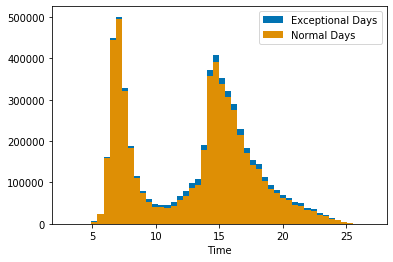

In [114]:
top = sns.distplot(journeys.o_time_fl, kde=False, label="Exceptional Days", hist_kws={"alpha": 1})
bot = sns.distplot(journeys[journeys.exc == 0].o_time_fl, kde=False, label="Normal Days", hist_kws={"alpha": 1})
plt.legend()
plt.xlabel("Time")
plt.show()

### Mark AM values

In [115]:
journeys['am'] = 0
mask = (journeys['o_time_fl'] > 3) & (journeys['o_time_fl'] < 12)
journeys.loc[mask, 'am'] = 1

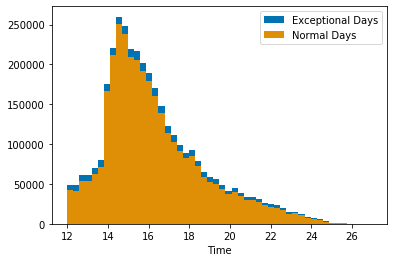

In [116]:
df = journeys[journeys.am == 0]
top = sns.distplot(df.o_time_fl, kde=False, label="Exceptional Days", hist_kws={"alpha": 1})
bot = sns.distplot(df[df.exc == 0].o_time_fl, kde=False, label="Normal Days", hist_kws={"alpha": 1})
plt.legend()
plt.xlabel("Time")
plt.show()

### Convert to GDF

In [55]:
geometry = [Point(xy) for xy in zip(journeys['o_lon'], journeys['o_lat'])]
crs = {'init': 'epsg:4326'}
journeys_gdf = gpd.GeoDataFrame(journeys, crs=crs, geometry=geometry)

Pickle this so I don't have to re-execute it.

In [ ]:
pickle_it(journeys_gdf, "journeys_gdf.p")

Retrieve pickle

In [56]:
journeys_gdf = unpickle("journeys_gdf.p")

In [57]:
journeys_gdf.head()

,card,svc_date,type,jnysqn,o_datetime,o_id,o_name,o_lat,o_lon,o_parent,...,d_lat,d_lon,d_parent,o_time_fl,winter,holiday,early_release,exc,am,geometry
2,/GKYO5Q2weIJbttWepQ3xmEwlf8kity,2019-06-11,m7,2,2019-06-11 17:04:03,42819,Hyde Park Ave @ Wolcott Square,42.237363,-71.132128,NaN,...,NaN,NaN,NaN,17.067500,0,0,0,0,0,POINT (-71.13212800000001 42.237363)
3,vQrtq3LAWGJKztB6KwNeUPQcud/9afy,2018-10-22,m7,4,2018-10-22 11:39:52,place-north,North Station,42.365577,-71.061290,NaN,...,42.355518,-71.060225,NaN,11.664444,0,0,0,0,1,POINT (-71.06129 42.365577)
4,AcN5/Uswaufej6XwoSooIouLuO585Bu,2019-05-07,m7,4,2019-05-07 22:32:27,place-bbsta,Back Bay,42.347350,-71.075727,NaN,...,NaN,NaN,NaN,22.540833,0,0,0,0,0,POINT (-71.075727 42.34735)
5,f33pKSIeNy8ZFJ8OI9NkKA.v4bx9fwu,2019-01-04,m7,1,2019-01-04 07:47:20,2906,Boston St opp Washburn St,42.325805,-71.058965,NaN,...,NaN,NaN,NaN,7.788889,0,0,0,0,1,POINT (-71.058965 42.325805)
6,18AdF1xG0SOR4ROHCDRaw0T2agO/57G,2019-03-19,m7,2,2019-03-19 07:28:05,place-coecl,Copley,42.349974,-71.077447,NaN,...,NaN,NaN,NaN,7.468056,0,0,0,0,1,POINT (-71.07744699999999 42.349974)


### Intersection with Buffers

In [60]:
len(journeys_gdf)

5780399

Limit to 1 to 7pm and "normal" days.

In [61]:
gdf = journeys_gdf[((journeys_gdf.o_time_fl > 13) & (journeys_gdf.o_time_fl < 19)) & (journeys_gdf.exc == 0)]

In [62]:
len(gdf)

2751026

#### Estimate Time

This is expected to take a long time, even if it is only on the 'normal' days and only for 1pm to 7pm. So estimate execution time below, using a random sample of 10,000 rows. Also, test which function 'intersect' or 'within' takes less time. For our purposes they do the same thing, but one might be quicker.

In [ ]:
sample = gdf.sample(n=10000)

In [ ]:
from datetime import datetime

In [ ]:
start_time = datetime.now()
intersections = sample.geometry.intersects(buffer_q.loc[0].geometry)
dur1 = datetime.now() - start_time
print("This script took " + str(dur1) + " to execute.")

In [ ]:
len(gdf)/10000*dur1.total_seconds()

In [165]:
start_time = datetime.now()
intersections = sample.geometry.within(buffer_q.loc[0].geometry)
dur2 = datetime.now() - start_time
print("This script took " + str(dur2) + " to execute.")

This script took 0:00:11.141030 to execute.


In [166]:
len(gdf)/10000*dur2.total_seconds()

3064.9263196780003

It doesn't look like there is a significant difference between the two functions. GeoSeries.intersects is slightly faster but it doesn't seem significant. I'll stick to .intersects.

The operation should take about 50 minutes.

#### Test Output

Ensure that the results are good. Export results to CSV and then visualize using ArcGIS.  
[ArcMap File](shp\map.mxd)

In [167]:
intersections = sample.geometry.intersects(buffer_q.loc[0].geometry)

In [168]:
sample['within_buffer_q'] = intersections

In [171]:
sample.to_csv("shp\sample_intersections.csv")

The results look great.

#### Limit to each card's first tap after 1pm

In [68]:
len(gdf)

2751026

In [69]:
gdf.head(1)

,card,svc_date,type,jnysqn,o_datetime,o_id,o_name,o_lat,o_lon,o_parent,...,d_lon,d_parent,o_time_fl,winter,holiday,early_release,exc,am,geometry,within_buffer_q
2,/GKYO5Q2weIJbttWepQ3xmEwlf8kity,2019-06-11,m7,2,2019-06-11 17:04:03,42819,Hyde Park Ave @ Wolcott Square,42.237363,-71.132128,NaN,...,NaN,NaN,17.0675,0,0,0,0,0,POINT (-71.13212800000001 42.237363),True


In [70]:
first_pm_taps = gdf.sort_values('o_time_fl').groupby(['svc_date','card']).first()

In [71]:
len(first_pm_taps)

1984649

In [79]:
crs = {'init': 'epsg:4326'}
first_pm_taps = gpd.GeoDataFrame(first_pm_taps, crs=crs, geometry=first_pm_taps.geometry)

In [80]:
first_pm_taps.head(1)

,,type,jnysqn,o_datetime,o_id,o_name,o_lat,o_lon,o_parent,d_datetime,d_id,...,d_lon,d_parent,o_time_fl,winter,holiday,early_release,exc,am,geometry,within_buffer_q
svc_date,card,,,,,,,,,,,,,,,,,,,,,
2018-09-06,..BG1tgP42qt8X7iwexvU328wBi3p5y,m7,1,2018-09-06 14:16:43,place-ccmnl,Community College,42.373622,-71.069533,NaN,2018-09-06 14:39:50,place-bbsta,...,-71.075727,NaN,14.278611,0,0,0,0,0,POINT (-71.06953299999999 42.373622),False


#### Actually Run Script

For 0.25 mile buffer

In [178]:
start_time = datetime.now()
intersections = gdf.geometry.intersects(buffer_q.loc[0].geometry)
dur2 = datetime.now() - start_time
print("This script took " + str(dur2) + " to execute.")

This script took 0:56:11.398182 to execute.


In [179]:
gdf['within_buffer_q'] = intersections

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [205]:
pickle_it(gdf, "gdf.p")

In [63]:
gdf = unpickle("gdf.p")

For 0.5 mile buffer

In [82]:
intersections = first_pm_taps.geometry.intersects(buffer_h.loc[0].geometry)
# Executed at 16:07

In [83]:
first_pm_taps['within_buffer_h'] = intersections

In [86]:
first_pm_taps.head(1)

,,type,jnysqn,o_datetime,o_id,o_name,o_lat,o_lon,o_parent,d_datetime,d_id,...,d_parent,o_time_fl,winter,holiday,early_release,exc,am,geometry,within_buffer_q,within_buffer_h
svc_date,card,,,,,,,,,,,,,,,,,,,,,
2018-09-06,..BG1tgP42qt8X7iwexvU328wBi3p5y,m7,1,2018-09-06 14:16:43,place-ccmnl,Community College,42.373622,-71.069533,NaN,2018-09-06 14:39:50,place-bbsta,...,NaN,14.278611,0,0,0,0,0,POINT (-71.06953299999999 42.373622),False,True


#### Pickle Results

In [85]:
pickle_it(first_pm_taps, "first_pm_taps.p")

In [ ]:
first_pm_taps = unpickle("first_pm_taps.p")

#### Explore Results

In [93]:
taps = first_pm_taps

In [64]:
print(len(first_pm_taps[first_pm_taps.within_buffer_q == True]))
len(gdf)

1386229


2751026

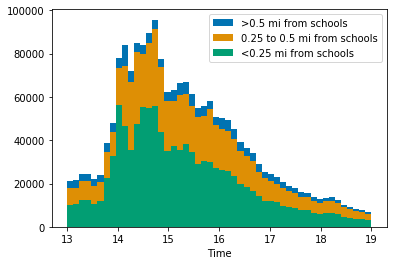

In [117]:
sns.distplot(taps.o_time_fl, kde=False, label=">0.5 mi from schools", hist_kws={"alpha": 1})
sns.distplot(taps[taps.within_buffer_h == True].o_time_fl, kde=False, label="0.25 to 0.5 mi from schools", hist_kws={"alpha": 1})
sns.distplot(taps[taps.within_buffer_q == True].o_time_fl, kde=False, label="<0.25 mi from schools", hist_kws={"alpha": 1})
plt.legend()
plt.xlabel("Time")
plt.show()

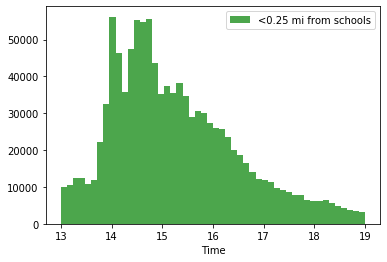

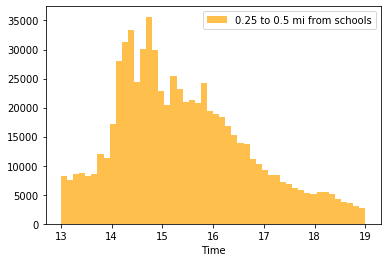

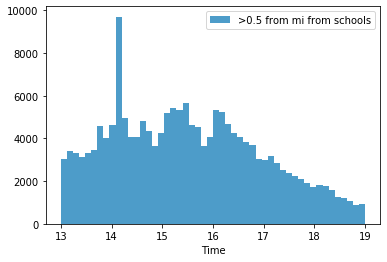

In [119]:
sns.distplot(taps[taps.within_buffer_q == True].o_time_fl, kde=False, label="<0.25 mi from schools", hist_kws={"alpha": 0.7}, color='green')
plt.legend()
plt.xlabel("Time")
plt.show()

sns.distplot(taps[(taps.within_buffer_h == True) & (taps.within_buffer_q == False)].o_time_fl, kde=False, 
             label="0.25 to 0.5 mi from schools", hist_kws={"alpha": 0.7}, color='orange')
plt.legend()
plt.xlabel("Time")
plt.show()

sns.distplot(taps[taps.within_buffer_h == False].o_time_fl, kde=False, label=">0.5 from mi from schools", hist_kws={"alpha": 0.7})
plt.legend()
plt.xlabel("Time")
plt.show()

#### Get some numbers

In [172]:
len(taps)

1984649

In [169]:
len(taps[taps.within_buffer_q == True])

1090051

In [170]:
len(taps[(taps.within_buffer_h == True) & (taps.within_buffer_q == False)])

716749

In [171]:
len(taps[taps.within_buffer_h == False])

177849

### Summarize by Card

In [123]:
card_groups = taps.groupby(['card'])

In [124]:
len(card_groups.type.count())

40586

In [125]:
card_groups.type.count().mean()

48.89984231015621

In [126]:
card_groups.type.count().std()

44.62869906311693

In [127]:
card_groups.count().head(1)

,type,jnysqn,o_datetime,o_id,o_name,o_lat,o_lon,o_parent,d_datetime,d_id,...,d_parent,o_time_fl,winter,holiday,early_release,exc,am,geometry,within_buffer_q,within_buffer_h
card,,,,,,,,,,,,,,,,,,,,,
..BG1tgP42qt8X7iwexvU328wBi3p5y,119,119,119,119,119,119,119,1,101,101,...,1,119,119,119,119,119,119,119,119,119


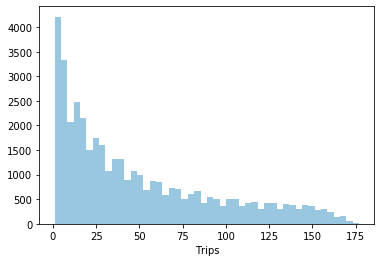

In [128]:
sns.distplot(card_groups.type.count(), kde=False)
plt.xlabel("Trips")
plt.show()

In [140]:
cards = pd.DataFrame()

In [141]:
cards['days'] = card_groups.type.count()

In [142]:
cards['within_q'] = card_groups.within_buffer_q.sum()

In [143]:
cards['within_h'] = card_groups.within_buffer_h.sum()

In [146]:
cards['outside_h'] = cards['days'] - cards['within_h']

In [147]:
cards['buffer_q_mean'] = card_groups.within_buffer_q.mean()

In [148]:
cards['buffer_h_mean'] = card_groups.within_buffer_h.mean()

In [149]:
cards['time_mean'] = card_groups.o_time_fl.mean()

In [150]:
cards['time_std'] = card_groups.o_time_fl.std()

In [151]:
cards.head()

,days,within_q,within_h,buffer_q_mean,outside_h,buffer_h_mean,time_mean,time_std
card,,,,,,,,
..BG1tgP42qt8X7iwexvU328wBi3p5y,119,37.0,51.0,0.310924,68.0,0.428571,14.597885,1.005945
..KBgt73E0GomiY/9zTDsAepn6/99Lm,7,4.0,7.0,0.571429,0.0,1.000000,15.552540,0.740027
..OIKmYvjwOurrZzDuVCIrvl46Fv9wW,26,24.0,26.0,0.923077,0.0,1.000000,17.586976,1.515666
..ThIGAdvjEVc96iGlJGopsrumnh/Yu,1,0.0,1.0,0.000000,0.0,1.000000,15.655833,NaN
..Yug.YFldp2IKHHQuM3nUEzhlh5ntC,55,41.0,50.0,0.745455,5.0,0.909091,16.490106,1.306086


Exploration

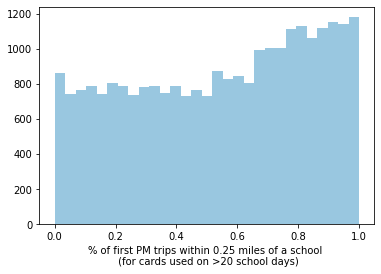

In [156]:
sns.distplot(cards[cards.days>20].buffer_q_mean, kde=False)
plt.xlabel("% of first PM trips within 0.25 miles of a school \n (for cards used on >20 school days)")
plt.show()

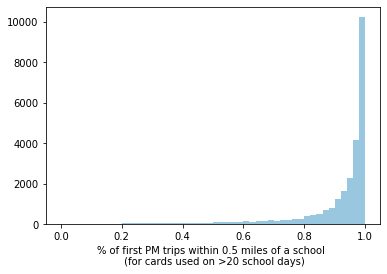

In [157]:
sns.distplot(cards[cards.days>20].buffer_h_mean, kde=False)
plt.xlabel("% of first PM trips within 0.5 miles of a school \n (for cards used on >20 school days)")
plt.show()

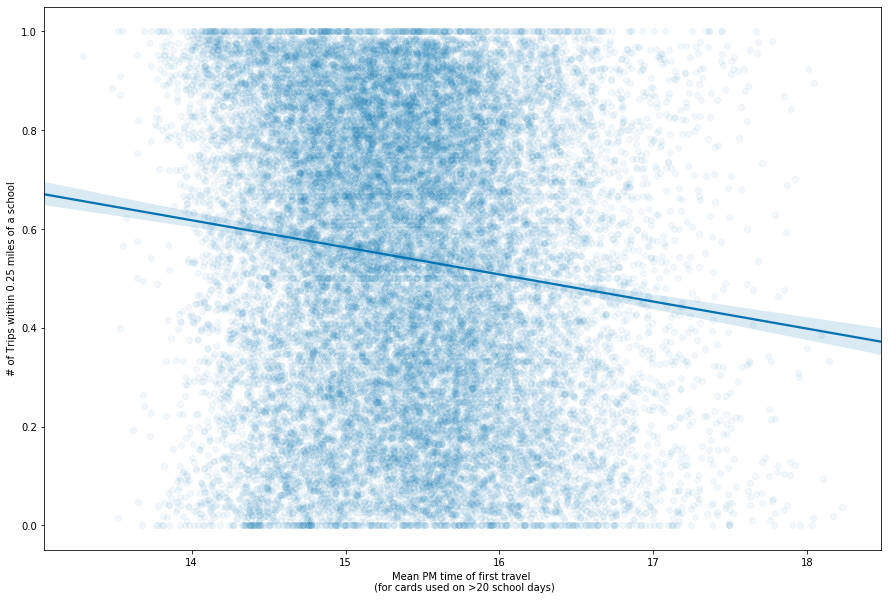

In [158]:
fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(cards[cards.days>20].time_mean, cards[cards.days>20].buffer_q_mean, ci=99.99, scatter_kws={'alpha':0.05})
plt.xlabel("Mean PM time of first travel \n (for cards used on >20 school days)")
plt.ylabel("# of Trips within 0.25 miles of a school")
plt.show()

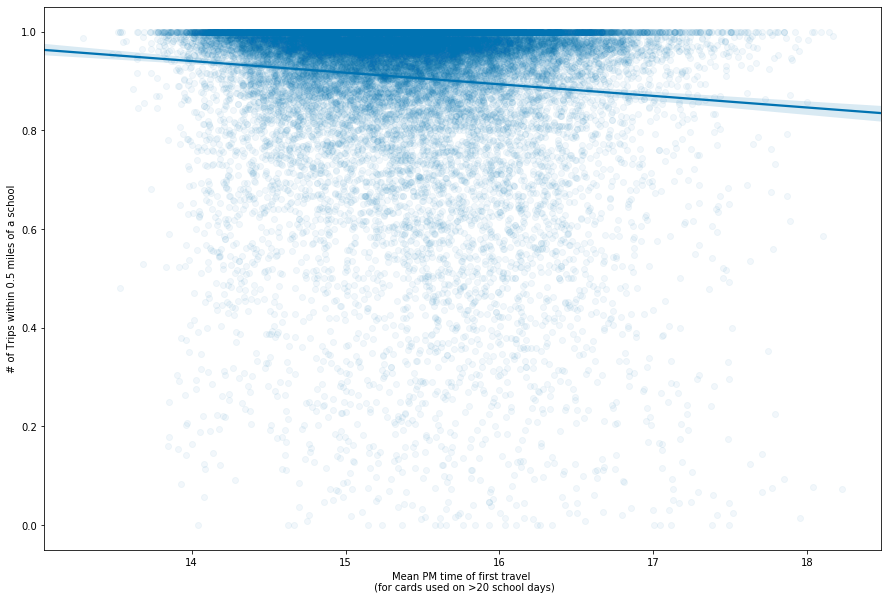

In [159]:
fig, ax = plt.subplots(figsize=(15,10))
sns.regplot(cards[cards.days>20].time_mean, cards[cards.days>20].buffer_h_mean, ci=99.99, scatter_kws={'alpha':0.05})
plt.xlabel("Mean PM time of first travel \n (for cards used on >20 school days)")
plt.ylabel("# of Trips within 0.5 miles of a school")
plt.show()

99.99% confidence interval shows a slightly negative correlation between the probability that a given card taps near a school and the average time of that same card’s taps.

#### Classify cards with 20+ days used into four groups based on these two characteristics:

In [182]:
import ipywidgets as widgets
from ipywidgets import HBox, Label
from IPython.display import display
%matplotlib nbagg

In [ ]:
df = cards[cards.days>20]

In [228]:
def classify_cards(time_co, buffer_co, buffer_size):
    buffer_col = 'buffer_' + buffer_size + '_mean'
    total = len(df)
    a = len(df[(df.time_mean > time_co) & (df[buffer_col] >= buffer_co)])
    b = len(df[(df.time_mean > time_co) & (df[buffer_col] < buffer_co)])
    c = len(df[(df.time_mean <= time_co) & (df[buffer_col] < buffer_co)])
    d = len(df[(df.time_mean <= time_co) & (df[buffer_col] >= buffer_co)])
    print (list((x, x/total) for x in [a, b, c, d]))

In [235]:
time_co = HBox([Label('Average first PM tap time:'), 
                widgets.FloatSlider(min=13, max=17, value=16, step=0.1, readout_format='.1f')])
buffer_co = HBox([Label('Proportion of first PM trips within buffer:'), 
                widgets.FloatSlider(min=0, max=1, value=0.5, step=0.05)])
buffer_size = HBox([Label('Buffer size (mi):'), 
                   widgets.Dropdown(options=[(0.25, 'q'), (0.5, 'h')],)])

widgets.interactive(classify_cards, time_co=time_co.children[1], buffer_co=buffer_co.children[1], buffer_size=buffer_size.children[1])

interactive(children=(FloatSlider(value=16.0, description='time_co', max=17.0, min=13.0, readout_format='.1f')…

In [230]:
df = cards[cards.days>20]
total = len(df)
time_co = 16
buffer_co = 0.5
print(total)

x = len(df[(df.time_mean > time_co) & (df.buffer_q_mean >= buffer_co)])
print(x, x/total*100)
x = len(df[(df.time_mean > time_co) & (df.buffer_q_mean < buffer_co)])
print(x, x/total*100)
x = len(df[(df.time_mean <= time_co) & (df.buffer_q_mean < buffer_co)])
print(x, x/total*100)
x = len(df[(df.time_mean <= time_co) & (df.buffer_q_mean >= buffer_co)])
print(x, x/total*100)

25797
2175 8.431212931736248
2523 9.780207000814048
8579 33.25580493855875
12520 48.532775128890954


In [231]:
df.time_mean.mean()

15.382300089270691

In [232]:
df.time_mean.std()

0.6964829126863374

In [233]:
df.buffer_q_mean.mean()

0.5419017347468791

In [234]:
df.buffer_h_mean.mean()

0.9077788907961025